## Sniffer
---
"Sniff out good and bad images in your dataset"

Row(background='#6eb4f5', height=600, sizing_mode='fixed', width=900)
    [0] Column(background='#b9d5f0', height=250, margin=(55, 5), sizing_mode='fixed', width=100)
        [0] Button(button_type='success', disabled=True, margin=(10, 20), name='YES', sizing_mode='stretch_width', width=50)
        [1] Button(button_type='danger', disabled=True, margin=(10, 20), name='NO', sizing_mode='stretch_width', width=50)
        [2] Button(button_type='warning', disabled=True, margin=(10, 20), name='UNDO', sizing_mode='stretch_width', width=35)
    [1] Column(background='#b9d5f0', height=600, margin=(5, 0), sizing_mode='fixed', width=500)
        [0] ParamMethod(method, sizing_mode='stretch_width')
        [1] StaticText(margin=(5, 120), sizing_mode='stretch_width', value='Click THUMBNAIL t...)
        [2] Row(sizing_mode='stretch_width')
            [0] Button(button_type='success', margin=(10, 20), name='THUMBNAIL', sizing_mode='stretch_width', width=50)
            [1] Button(button_type='success', margin=(10, 20), name='IMAGE', sizing_mode='stretch_width', width=50)
        [3] ParamMethod(method, sizing_mode='stretch_width')
        [4] ParamMethod(method, sizing_mode='stretch_width')
    [2] Column(background='#b9d5f0', height=250, margin=(55, 5), sizing_mode='fixed', width=230)
        [0] RadioButtonGroup(margin=(40, 1), name='Radio Button Group', options=['CSV Mode', 'File Mode'], sizing_mode='stretch_width', value='CSV Mode')
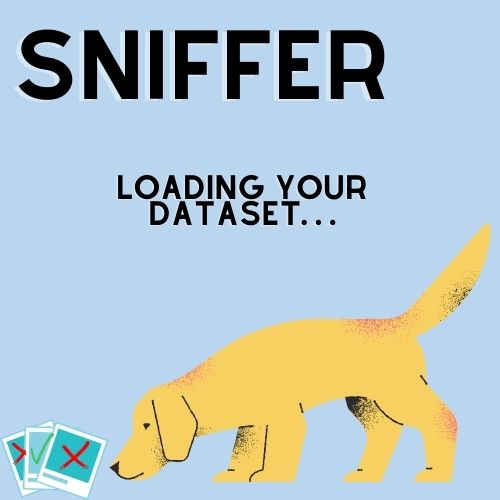

In [3]:
# New import for creating hotkeys
import pynput

import shutil
import panel as pn
import param
import os
from PIL import Image
import asyncio
import glob
import csv
import pandas as pd
from datetime import datetime
import holoviews as hv
pn.extension()
pn.extension(loading_spinner='dots', loading_color='#00aa41', sizing_mode="stretch_width")


class SnifferClass(param.Parameterized):
    photo_index                 = param.Integer(0)
    
    # Widgets
    thumbnail_button = pn.widgets.Button(name='THUMBNAIL',button_type='success',width=50,margin=(10,20))
    image_button = pn.widgets.Button(name='IMAGE',width=50,button_type='success',margin=(10,20))
    
    yes_button = pn.widgets.Button(name='YES',width=50,button_type='success',margin=(10,20))
    no_button = pn.widgets.Button(name='NO',width=50,button_type='danger', margin=(10,20))
    undo_button = pn.widgets.Button(name='UNDO',width=35,button_type='warning', margin=(10,20))
    # Mode selector
    radio_group = pn.widgets.RadioButtonGroup(
        name='Radio Button Group', options=['CSV Mode', 'File Mode'],margin=(40,1))
    text = pn.widgets.StaticText(margin=(5,120))
    photo_index_text = pn.widgets.StaticText(margin=(5,120))

    def __init__(self, **params):
        super().__init__(**params)
        # initialize the photo index to -1 to indicate no thumbnails have been loaded yet
        self.photo_index=-1
        # Disable Thumbnail mode by default and use original images
        self.thumbnail_mode=False
        # Variables for images
        self.csv_file_location=""
        self.photos_dir_location=os.getcwd()+os.sep + "images"
        #fix issues with the file extensions by converting to lowercase jpg
        self.lowercase_ext(".JPG",".jpg")
        jpg_list = glob.glob(self.photos_dir_location+os.sep+"*jpg")
        # photos_list contains the jpgs in the images directory
        self.photos_list=map(lambda x:os.path.basename(x),jpg_list )
        self.photos_list=list(self.photos_list)
        # Location of the thumbnails directory
        self.thumbnails_dir_loc=os.getcwd()+os.sep+"thumbnails"     
        
        self.last_index_photos_list=len(self.photos_list) -1
        # inital_photo will be the first image from the user dataset to be display in the jpg panel
#         self.inital_photo=self.photos_dir_location+os.sep+self.photos_list[0]
        if self.quality_control(self.photos_dir_location,self.photos_list)==False:
            raise FileNotFoundError (f"{self.photos_dir_location} contains no jpgs")

        # Disable all buttons except thumbnail and image buttons
        self.modify_button_state(True)
        self.text.value="Click THUMBNAIL to create thumbnails for all images or IMAGE to use the original images.\
        \n WARNING: If you choose IMAGE and your images are too large switching images may take longer. "

        
    def lowercase_ext(self,old_file_ext:str, file_ext:str):
        photos_dir_location=os.getcwd()+os.sep + "images"
        JPGs_list = glob.glob(photos_dir_location+os.sep+"*"+old_file_ext)
        for JPG in JPGs_list:
            src=JPG
            dest=os.path.splitext(JPG)[:-1]
            #convert the tuple to a string
            new_dest="".join(map(str,dest))
            # append the new file extension to the new filename
            new_dest=new_dest+file_ext
            os.rename(src, new_dest)
            
            
    def create_thumbnails(self, photos_dir_location:str, photos_list:list):
        if not os.path.exists(self.thumbnails_dir_loc):
            os.mkdir(self.thumbnails_dir_loc)
        elif os.path.exists(self.thumbnails_dir_loc):
            #if there are any old files in the thumbnail directory delete them
            for file in os.listdir(self.thumbnails_dir_loc):
                os.remove(os.path.join(self.thumbnails_dir_loc,file))
        # Create a thumbnail for each photo in photos list
        for photo in photos_list:
            photo_loc=photos_dir_location+os.sep+photo
            # resize the thumbnails and save them to thumbnails directory
            im = Image.open(photo_loc)
            MAX_SIZE=(500,500)
            im.thumbnail(MAX_SIZE) 
#             new_im=im.resize([500,500],Image.BICUBIC)
            thumbnail_loc = self.thumbnails_dir_loc+os.sep+photo
            im.save(thumbnail_loc)
#             new_im.save(thumbnail_loc)        
               
        
    def get_jpg_panel(self):
        # Index = -1 mean Sniffer just loaded
        loading_jpg=os.getcwd()+os.sep + "assets"+os.sep+"new_loading_sniffer.jpg"
        if self.photo_index==-1:
            self.jpg_panel=pn.pane.JPG(loading_jpg, width=450, height=450,sizing_mode='fixed',margin=(0,25))
        elif self.photo_index==-2:
            # Index = -2 it means the THUMBNAIL button was pressed
            self.jpg_panel=pn.pane.JPG(loading_jpg, width=450, height=450,sizing_mode='fixed',margin=(0,25))
            self.jpg_panel.loading=True
        elif self.photo_index <= self.last_index_photos_list:
            self.jpg_panel.loading=False
            self.undo_button.disabled=False
                                     
            if self.thumbnail_mode == True:
                new_photo=self.thumbnails_dir_loc+os.sep+self.thumbnails_list[self.photo_index]
            elif self.thumbnail_mode == False:
                new_photo=self.photos_dir_location+os.sep+self.photos_list[self.photo_index]
                                     
            self.jpg_panel.object=new_photo
        elif self.photo_index > self.last_index_photos_list:
            last_photo=os.getcwd()+ os.sep + "assets"+os.sep+"new_sniffer_done.jpg"
            self.jpg_panel.object=last_photo
        return self.jpg_panel
    
    def get_photo_index_text(self):
        if self.photo_index >= 0:
            self.photo_index_text.value = f"Current Index: # {self.photo_index}"
            return self.photo_index_text
    
    def get_progress_bar(self):
        if self.photo_index<0:   
            self.progress_bar = pn.indicators.Progress(name='Progress Bar',margin=(10,120),value=0,active=True, max=self.last_index_photos_list, bar_color='info', width=200)
        elif self.photo_index <= self.last_index_photos_list:
            self.progress_bar.value=self.photo_index
            self.progress_bar.bar_color='info'
        elif self.photo_index > self.last_index_photos_list:
            self.progress_bar.value=self.last_index_photos_list
            self.progress_bar.bar_color='success'
        return self.progress_bar
    
    def handle_all_images_processed(self):
        """ Check if all images have been processed, if so display the done image"""
        self.text.value = "All images have been processed."
        self.yes_button.disabled=True
        self.no_button.disabled=True
        
        
    def quality_control_failure(self):
        """ Quality control has failed disable all buttons and display error message """
        self.modify_button_state(True)
        self.text.value=f"ERROR: There are no images in\n{photos_dir_location}"
    
    
    def quality_control(self,photos_dir_location,photos_list):
        """Helper function to check if the photos_dir_location exists and that it contains jpgs. Returns false if either check fails"""
        if not os.path.isdir(photos_dir_location):
                os.mkdir(photos_dir_location)
                return False
        bad_images_path=os.getcwd()+os.sep+"bad_images"
        good_images_path=os.getcwd()+os.sep+"good_images"
        if not os.path.exists(bad_images_path):
            os.mkdir(bad_images_path)
        if not os.path.exists(good_images_path):
            os.mkdir(good_images_path) 
        if len(photos_list)==0:
                return False
    #         If neither of these return false it means quality control passed
        return True   

    
    def create_csv(self):
        today = datetime.now()
        d1 = today.strftime("%d_%m_%Y_hr_%H_%M")
        filename=f"Sniffer_Output_"+d1+".csv"
        csv_path = os.getcwd()+os.sep+filename
        with open(csv_path, 'w', newline='') as outcsv:
            writer = csv.writer(outcsv)
            writer.writerow(["Filename", "Sorted","index"])
        return csv_path    


    def delete_image_from_csv(self,filename:str, csv_file: str):
        """Removes the filename from the csv file"""
        if not os.path.exists(csv_file):
            return
        df = pd.read_csv(csv_file)
        # Get the index in the csv where the filename to be removed is located
        index=df.loc[df["Filename"] == filename].index.values
        df.drop(index,axis=0,inplace=True)
        # Delete the csv csv file
        os.remove(csv_file)
        self.text.value=f"{filename}"
        df.to_csv(csv_file, index=False)
    
    
    def delete_image(self,filename:str):
        """Deletes the file called filename from either the good_images or bad_images directory"""
        bad_images_path=os.getcwd()+os.sep+"bad_images"
        good_images_path=os.getcwd()+os.sep+"good_images"
        locations=[bad_images_path,good_images_path]
        # Check if the file exists in either of the directories if it doesn't raise FileNotFound
        for location in locations:
                image_location=self.find_image(location, filename)
                if image_location !=None:
                    os.remove(image_location)
                    return # If the file cannot be found then it proceeds normally


    def find_image(self,file_path:str, filename:str)->str:
        """Looks for the filename (without the extension) in the file_path and returns the location of the file.Otherwise it returns None """
        # Remove the extension from the filename
        filename=os.path.splitext(filename)[0]
        # Check if the directory exists if it doesn't then don't search it
        if os.path.isdir(file_path):
        # See if the filename exists in the directory and return the extact location
            for file in os.listdir(file_path):
                if filename in file:
                    return (file_path+os.sep+file)
            return None


    def copy_image(self,photo_loc:str, sort_type:str):
        """COPY photo_loc to the sorted_images directory with the sort_type appended to the filename"""        
        # Copy the images into the good or bad directories depending on the button clicked
        if "bad" in sort_type:
            sorted_images_path=os.getcwd()+os.sep+"bad_images"
        elif "good" in sort_type:
            sorted_images_path=os.getcwd()+os.sep+"good_images"
        else:
            sorted_images_path=os.getcwd()+os.sep+"sorted_images"
        # Check if the sorted dir exists if it doesn't create it
        if not os.path.isdir(sorted_images_path):
            os.mkdir(sorted_images_path)

        # Change the filename of the photo_loc
        new_filename=self.change_filename(os.path.basename(photo_loc),sort_type,sorted_images_path)

        # Move the image from images into sorted_images
        shutil.copyfile(photo_loc, new_filename)
    

    def change_filename(self,old_filename:str, sort_type:str, photos_dir:str):
        """Appends sort_type to the end of the filename. Returns the location of the file in the location with photos_dir"""
        new_filename=os.path.splitext(old_filename)
        new_filename=new_filename[0]+"_"+str(sort_type)+new_filename[1]
        new_photo_loc=photos_dir+os.sep+new_filename
        return new_photo_loc
    
    def handle_file_choice(self, sort_type:str):
        """Sorts the current file into a good or bad directory depending on the yes/no choice
           when file mode is active
        
        Arguments:
        -----------
        sort_type: str
            -"good": sort the image as a good image
            -"bad": sort the image as a bad image 
        """
        quality_control_passed=self.quality_control(self.photos_dir_location,self.photos_list)
        if not quality_control_passed:
            self.quality_control_failure()
        elif quality_control_passed:
            self.modify_button_state(True)
            self.text.value = f'Saving image #{self.photo_index} / {self.last_index_photos_list} as {sort_type}'
            await self.save_sorted_image(self.photo_index,sort_type)
            self.photo_index+=1
            # Check if all images have been processed, if so display the done image
            if self.photo_index > self.last_index_photos_list:
                self.handle_all_images_processed()
                self.yes_button.disabled=True
                self.no_button.disabled=True
                self.undo_button.disabled=False
            # Still more jpgs to check
            else:
                self.text.value = f'Saved image # {self.photo_index-1} / {self.last_index_photos_list} as {sort_type}'
                self.modify_button_state(False)

    def handle_csv_choice(self, sort_type:str):
        """Sorts the current file as a good or bad type in the csv file depending on the yes/no choice
           when csv mode is active
        
        Arguments:
        -----------
        sort_type: str
            -"good": sort the image as a good image
            -"bad": sort the image as a bad image 
        """
        if not os.path.exists(self.csv_file_location):
                self.csv_file_location=self.create_csv()
        # Save the image filename to the csv file and the type of sort as good
        with open(self.csv_file_location, 'a', newline='') as outcsv:
            writer = csv.writer(outcsv)
            writer.writerow([self.photos_list[self.photo_index], sort_type, self.photo_index])
        self.photo_index+=1
        # Check if all images have been processed, if so display the done image
        if self.photo_index > self.last_index_photos_list:
            self.handle_all_images_processed()
            self.yes_button.disabled=True
            self.no_button.disabled=True
            self.undo_button.disabled=False
        # Still more jpgs to check
        else:
            self.text.value=f"Saved image # {self.photo_index-1} / {self.last_index_photos_list}  as {sort_type}"
            self.modify_button_state(False)
                       
                
    def save_sorted_image(self,index,sort_type):
        photo_loc=self.photos_dir_location+os.sep+self.photos_list[index]
        self.copy_image(photo_loc, sort_type)
    
    
    def thumbnail_button_clicked(self,event):
         if (event.obj.name == "THUMBNAIL" ):
            self.text.value= "THUMBNAIL button clicked! Creating Thumbnails."
            # Sniffer variable indicating it will display thumbnails in the jpg panel
            self.thumbnail_mode=True
            # Setting photo_index =-2 forces JPG Panel to display loading spinner
            self.photo_index=-2
            # Set the jpg panel to loading while the thumbnails are created
            self.jpg_panel.loading=True
            if self.photo_index < 0:
                # Create the thumbnails in the thumbnails directory
                self.thumbnails_dir_loc=os.getcwd()+os.sep+"thumbnails"
                self.create_thumbnails(self.photos_dir_location, self.photos_list)
                thumbnail_jpgs = glob.glob(self.photos_dir_location+os.sep+"*jpg")
                self.thumbnails_list=map(lambda x:os.path.basename(x),thumbnail_jpgs)
                self.thumbnails_list=list(self.thumbnails_list)
                # Complete the loading and enable all the button except IMAGE and THUMBNAIL
                self.photo_index=0
                self.jpg_panel.loading=False
                self.thumbnail_button.disabled=True
                self.image_button.disabled=True
                self.thumbnail_button.visible=False
                self.image_button.visible=False            
                self.modify_button_state(False)
                self.text.value="Click YES or NO to begin!"
                                     
    def image_button_clicked(self,event):
         if (event.obj.name == "IMAGE" ):
            # Sniffer variable indicating it will display the original jpgs in the jpg panel
            self.thumbnail_mode=False
            #self.text.value= f"IMAGE button clicked!{self.thumbnail_mode}"
            # Enable all the button except IMAGE and THUMBNAIL
            self.photo_index=0
            self.text.value= f"IMAGE button clicked!{self.photo_index}"
            self.thumbnail_button.disabled=True
            self.image_button.disabled=True
            self.thumbnail_button.visible=False
            self.image_button.visible=False            
            self.modify_button_state(False)
            self.text.value=f"Click YES or NO to begin!{self.photo_index}"
                
    
    async def yes_button_clicked(self,event):
        if (event.obj.name == "YES" and self.radio_group.value == "File Mode" ):
            await self.handle_file_choice("good")
        elif (event.obj.name == "YES" and self.radio_group.value == "CSV Mode" ):
            await self.handle_csv_choice("good")
    
    def yes_hotkey(self):
#         print("YES HOTKEY FUNCTION ACTIVATED")
        if (self.radio_group.value == "File Mode"):
             self.handle_file_choice("good")
        elif (self.radio_group.value == "CSV Mode"):
             self.handle_csv_choice("good")
    
    def no_hotkey(self):
#         print("NO HOTKEY FUNCTION ACTIVATED")
        if(self.radio_group.value == "File Mode" ):
             self.handle_file_choice("bad")
        elif (self.radio_group.value == "CSV Mode" ):
             self.handle_csv_choice("bad")

    def  no_button_clicked(self,event):
        if(self.radio_group.value == "File Mode" ):
             self.handle_file_choice("bad")
        elif (self.radio_group.value == "CSV Mode" ):
             self.handle_csv_choice("bad")
    
    def undo_hotkey(self):
#         print("UNDO HOTKEY FUNCTION ACTIVATED")
        if(self.radio_group.value=="File Mode"):
                quality_control_passed=self.quality_control(self.photos_dir_location,self.photos_list)
                if not quality_control_passed:
                    self.quality_control_failure()
                    self.modify_button_state(True)
                    self.text.value = f'Undo last image #{base.photo_index}'
                if self.photo_index == 0 or self.photo_index < 0:
                    self.photo_index = 0
                    self.text.value = f'Cannot undo image. None Left'
                    self.undo_button.disabled=True
                    self.yes_button.disabled=False
                    self.no_button.disabled=False
                else:
                    # Decrease the photo's index so it goes back one 
                    self.photo_index-=1
                    self.text.value = f'Undo last image: {self.photos_list[self.photo_index]} index: {self.photo_index}'
                    # Delete the old file from good or bad directory
                    self.delete_image(self.photos_list[self.photo_index])          
                    # Update the jpg panel
                    new_photo=self.photos_dir_location+os.sep+self.photos_list[self.photo_index]
                    self.jpg_panel.object=new_photo
                    self.text.value = f'Undo completed image #{self.photo_index}'
                    self.modify_button_state(False)
        elif(self.radio_group.value=="CSV Mode"):
                if self.photo_index == 0 or self.photo_index < 0:
                    self.photo_index = 0
                    self.text.value = f'Cannot undo image. None Left'
                    self.undo_button.disabled=True
                    self.yes_button.disabled=False
                    self.no_button.disabled=False
                else:
                    # Decrease the photo's index so it goes back one 
                    self.photo_index-=1
                    self.text.value = f'Undo last image: {self.photos_list[self.photo_index]} index: {self.photo_index}'
                    # Delete the old file from csv
                    self.delete_image_from_csv(self.photos_list[self.photo_index], self.csv_file_location)
                    # Update the jpg panel
                    new_photo=self.photos_dir_location+os.sep+self.photos_list[self.photo_index]
                    self.jpg_panel.object=new_photo
                    self.text.value = f'Undo completed image #{self.photo_index}'
                    self.modify_button_state(False)
    
                                     
    async def undo_button_clicked(self,event):
        if(event.obj.name == "UNDO" and self.radio_group.value=="File Mode"):
                quality_control_passed=self.quality_control(self.photos_dir_location,self.photos_list)
                if not quality_control_passed:
                    self.quality_control_failure()
                    self.modify_button_state(True)
                    self.text.value = f'Undo last image #{base.photo_index} / {self.last_index_photos_list}'
                if self.photo_index == 0 or self.photo_index < 0:
                    self.photo_index = 0
                    self.text.value = f'Cannot undo image. None Left'
                    self.undo_button.disabled=True
                    self.yes_button.disabled=False
                    self.no_button.disabled=False
                else:
                    # Decrease the photo's index so it goes back one 
                    self.photo_index-=1
                    self.text.value = f'Undo last image: {self.photos_list[self.photo_index]} index: {self.photo_index}'
                    # Delete the old file from good or bad directory
                    self.delete_image(self.photos_list[self.photo_index])          
                    # Update the jpg panel
                    new_photo=self.photos_dir_location+os.sep+self.photos_list[self.photo_index]
                    self.jpg_panel.object=new_photo
                    self.text.value = f'Undo completed image #{self.photo_index} / {self.last_index_photos_list}'
                    self.modify_button_state(False)
        elif(self.radio_group.value=="CSV Mode"):
                if self.photo_index == 0 or self.photo_index < 0:
                    self.photo_index = 0
                    self.text.value = f'Cannot undo image. None Left'
                    self.undo_button.disabled=True
                    self.yes_button.disabled=False
                    self.no_button.disabled=False
                else:
                    # Decrease the photo's index so it goes back one 
                    self.photo_index-=1
                    self.text.value = f'Undo last image: {self.photos_list[self.photo_index]} index: {self.photo_index}'
                    # Delete the old file from csv
                    self.delete_image_from_csv(self.photos_list[self.photo_index], self.csv_file_location)
                    # Update the jpg panel
                    new_photo=self.photos_dir_location+os.sep+self.photos_list[self.photo_index]
                    self.jpg_panel.object=new_photo
                    self.text.value = f'Undo completed image #{self.photo_index} / {self.last_index_photos_list}'
                    self.modify_button_state(False)


    def modify_button_state(self,is_clickable:bool):
        self.yes_button.disabled=is_clickable
        self.no_button.disabled=is_clickable
        self.undo_button.disabled=is_clickable
        return
    

# Make an instance of the Sniffer Class   
sniffer_app = SnifferClass()

sniffer_app.thumbnail_button.on_click(sniffer_app.thumbnail_button_clicked)
sniffer_app.image_button.on_click(sniffer_app.image_button_clicked)
sniffer_app.yes_button.on_click(sniffer_app.yes_button_clicked)
sniffer_app.no_button.on_click(sniffer_app.no_button_clicked)
sniffer_app.undo_button.on_click(sniffer_app.undo_button_clicked)

from pynput import keyboard

def on_activate_yes():
#     print('<up> pressed')
    sniffer_app.yes_hotkey()

def on_activate_no():
#     print('<down> pressed')
    sniffer_app.no_hotkey()
    
def on_activate_undo():
#     print('<undo> pressed')
    sniffer_app.undo_hotkey()    

listener = keyboard.GlobalHotKeys({
        '<up>': on_activate_yes,
        '<down>': on_activate_no,
        '<left>': on_activate_undo})

listener.start()


component = pn.Row(
    pn.Column(sniffer_app.yes_button, sniffer_app.no_button, sniffer_app.undo_button, background='#b9d5f0',width=100,height=250,margin=(55,5)),
    pn.Column(sniffer_app.get_photo_index_text,sniffer_app.text,image_mode_selection,sniffer_app.get_progress_bar, sniffer_app.get_jpg_panel,background='#b9d5f0', height= 600, width=500,margin=(5,0),align='start',sizing_mode='fixed'),
    pn.Column(sniffer_app.radio_group,background='#b9d5f0', width=230,height=250,margin=(55,5)),
    width=900,
    height=600,
    background='#6eb4f5'
    )
component

In [ ]:
# Creates a template that can be served with the command
# panel serve Sniffer.ipynb from the command line
template = pn.template.MaterialTemplate(
    title='',
    logo='assets/sniffer_big.jpg',
    header_background='#b9d5f0',
    main=[component],
)
template.servable();
template